In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
df = pd.read_csv('../data/data_pp.csv')
df_fit = df.drop(['date_day','id','album_id','date_month','decade'],axis=1)
df_fit = df_fit.sort_values('date_year')

In [4]:
from sklearn.model_selection import TimeSeriesSplit

X = df_fit.drop(['billboard'],axis=1)
y = df_fit['billboard']



splitter = TimeSeriesSplit(n_splits=2)
for i_other,i_test in splitter.split(X, y):
    X_other, y_other = X.iloc[i_other], y.iloc[i_other]
    X_test, y_test = X.iloc[i_test], y.iloc[i_test]

In [5]:
from sklearn.decomposition import PCA

columns = []
for i in range(2):
    columns.append('principal component '+str(i))
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = columns)

principalDf.head()
finalDf = pd.concat([principalDf, df_fit[['billboard']]], axis = 1)
finalDf.columns

Index(['principal component 0', 'principal component 1', 'billboard'], dtype='object')

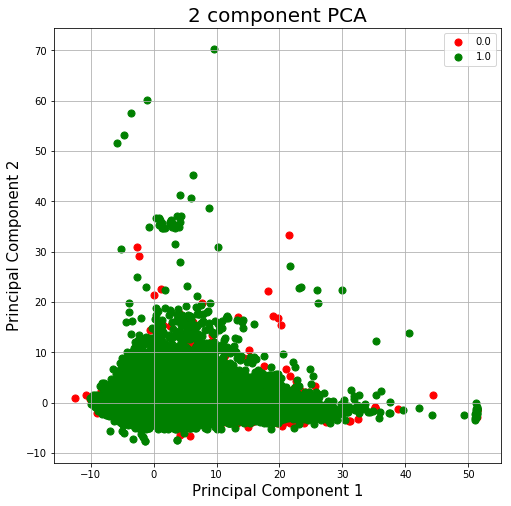

In [6]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0.0,1.0]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = (finalDf['billboard'] == target)
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 0']
               , finalDf.loc[indicesToKeep, 'principal component 1']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.savefig('../figures/PCA1_2.png')

---

In [229]:
file = open('../results/grid0.xgboost', 'rb')
grid_xgboost = pickle.load(file)
file.close()

In [230]:
X_test.columns

Index(['length', 'key', 'duration_ms', 'tempo', 'time_signature', 'loudness',
       'date_year', 'acousticness', 'speechiness', 'instrumentalness',
       'danceability', 'valence', 'liveness', 'mode', 'energy',
       'track_length'],
      dtype='object')

In [231]:
nr_runs = 10
scores = np.zeros([len(X_test.columns),nr_runs])

test_score = grid_xgboost.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = ',np.sum(y_test == 1)/len(y_test))
# loop through the features
for i in range(len(X_test.columns)):
    print('shuffling '+str(X_test.columns[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[X_test.columns[i]] = np.random.permutation(X_test[X_test.columns[i]].values)
        acc_scores.append(grid_xgboost.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.8864846785190521
test baseline =  0.8806957058687318
shuffling length
   shuffled test score: 0.87 +/- 0.0
shuffling key
   shuffled test score: 0.886 +/- 0.0
shuffling duration_ms
   shuffled test score: 0.885 +/- 0.0
shuffling tempo
   shuffled test score: 0.886 +/- 0.0
shuffling time_signature
   shuffled test score: 0.886 +/- 0.0
shuffling loudness
   shuffled test score: 0.886 +/- 0.0
shuffling date_year
   shuffled test score: 0.886 +/- 0.0
shuffling acousticness
   shuffled test score: 0.886 +/- 0.0
shuffling speechiness
   shuffled test score: 0.886 +/- 0.0
shuffling instrumentalness
   shuffled test score: 0.886 +/- 0.0
shuffling danceability
   shuffled test score: 0.886 +/- 0.0
shuffling valence
   shuffled test score: 0.886 +/- 0.0
shuffling liveness
   shuffled test score: 0.886 +/- 0.0
shuffling mode
   shuffled test score: 0.887 +/- 0.0
shuffling energy
   shuffled test score: 0.886 +/- 0.0
shuffling track_length
   shuffled test score: 0.884 +/- 0.0


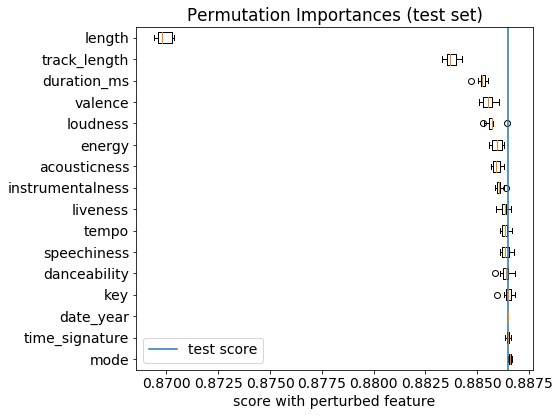

In [232]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=(X_test.columns)[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/feature_perm_imp_xgboost.png')
plt.show()

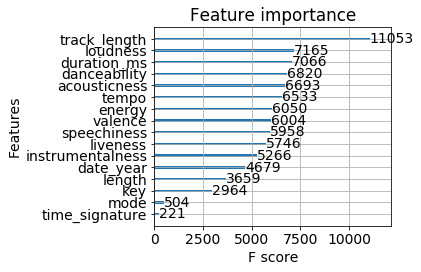

In [235]:
from sklearn.feature_selection import SelectFromModel

xgb = grid_xgboost.best_estimator_
xgb = xgb['xgbclassifier']
from xgboost import plot_importance
plot_importance(xgb)
plt.tight_layout()
plt.savefig('../figures/feature_imp_sfm_xgboost.png')

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.4,
              learning_rate=0.3, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, n_estimators=100, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=0.66, verbosity=1)>

---

In [54]:
ls ../results/randomForest/

grid0.RandomForest  grid1.RandomForest  grid2.RandomForest  grid3.RandomForest


In [7]:
for i in ['grid0.RandomForest','grid1.RandomForest','grid2.RandomForest','grid3.RandomForest']:
    file = open('../results/randomForest/'+i, 'rb')
    grid = pickle.load(file)
    file.close()
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:',grid.score(X_test,y_test))

{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 5}
best CV score: 0.8950995295136275
test score: 0.8825653296283908
{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 3}
best CV score: 0.895129543908151
test score: 0.8825653296283908
{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 2}
best CV score: 0.8950866624453713
test score: 0.8825653296283908
{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 2}
best CV score: 0.8951595616124367
test score: 0.8825224483494996


In [10]:
file = open('../results/randomForest/grid1.RandomForest', 'rb')
grid_randomforest = pickle.load(file)
file.close()
rndfor = grid_randomforest.best_estimator_['randomforestclassifier']

In [11]:
rndfor

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [12]:
nr_runs = 10
scores = np.zeros([len(X_test.columns),nr_runs])

test_score = grid_randomforest.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = ',np.sum(y_test == 1)/len(y_test))
# loop through the features
for i in range(len(X_test.columns)):
    print('shuffling '+str(X_test.columns[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[X_test.columns[i]] = np.random.permutation(X_test[X_test.columns[i]].values)
        acc_scores.append(grid_randomforest.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.8825653296283908
test baseline =  0.8806957058687318
shuffling length
   shuffled test score: 0.879 +/- 0.0
shuffling key
   shuffled test score: 0.883 +/- 0.0
shuffling duration_ms
   shuffled test score: 0.883 +/- 0.0
shuffling tempo
   shuffled test score: 0.883 +/- 0.0
shuffling time_signature
   shuffled test score: 0.883 +/- 0.0
shuffling loudness
   shuffled test score: 0.883 +/- 0.0
shuffling date_year
   shuffled test score: 0.883 +/- 0.0
shuffling acousticness
   shuffled test score: 0.883 +/- 0.0
shuffling speechiness
   shuffled test score: 0.883 +/- 0.0
shuffling instrumentalness
   shuffled test score: 0.883 +/- 0.0
shuffling danceability
   shuffled test score: 0.883 +/- 0.0
shuffling valence
   shuffled test score: 0.883 +/- 0.0
shuffling liveness
   shuffled test score: 0.883 +/- 0.0
shuffling mode
   shuffled test score: 0.883 +/- 0.0
shuffling energy
   shuffled test score: 0.883 +/- 0.0
shuffling track_length
   shuffled test score: 0.883 +/- 0.0


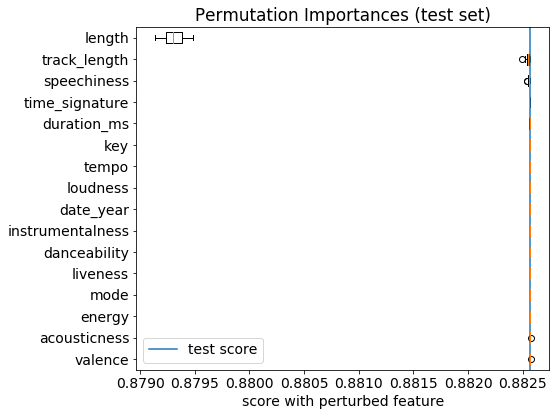

In [13]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=(X_test.columns)[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
names = X_test.columns
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rndfor.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.2049, 'date_year'), (0.2002, 'length'), (0.1715, 'track_length'), (0.0823, 'duration_ms'), (0.056, 'liveness'), (0.0451, 'speechiness'), (0.0379, 'acousticness'), (0.0372, 'loudness'), (0.0347, 'danceability'), (0.0322, 'energy'), (0.032, 'valence'), (0.0304, 'instrumentalness'), (0.0214, 'tempo'), (0.0088, 'key'), (0.0037, 'time_signature'), (0.0017, 'mode')]


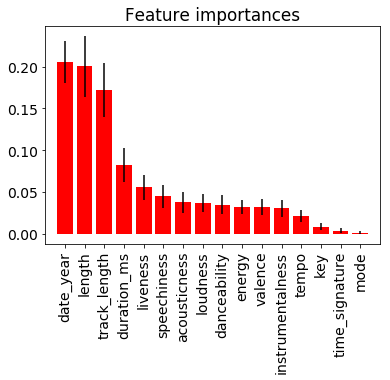

In [15]:
importances = rndfor.feature_importances_
std = np.std([tree.feature_importances_ for tree in rndfor.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_other.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_other.shape[1]), X_other.columns[indices],rotation=90)
plt.xlim([-1, X_other.shape[1]])
plt.show()

In [21]:
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

estimator = rndfor.estimators_[0]

export_graphviz(estimator, out_file='../figures/tree_randfor.dot', 
                feature_names = X_other.columns,
                class_names = ['0','1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

call(['dot', '-Tpng', '../figures/tree_randfor.dot', '-o', '../figures/tree_randfor.png', '-Gdpi=600'])

# Display in jupyter notebook

Image(filename = '../figures/tree_randfor.png')

In [121]:
rndfor.estimators_[1]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1273642419, splitter='best')

---

In [16]:
for i in ['grid0.adaboost','grid1.adaboost','grid2.adaboost','grid3.adaboost']:
    file = open('../results/adaboost/'+i, 'rb')
    grid = pickle.load(file)
    file.close()
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:',grid.score(X_test,y_test))

{'adaboostclassifier__algorithm': 'SAMME.R', 'adaboostclassifier__learning_rate': 1.0}
best CV score: 0.8941046834017559
test score: 0.8922307698904812
{'adaboostclassifier__algorithm': 'SAMME.R', 'adaboostclassifier__learning_rate': 0.1}
best CV score: 0.8941389896384584
test score: 0.8825653296283908
{'adaboostclassifier__algorithm': 'SAMME.R', 'adaboostclassifier__learning_rate': 1.0}
best CV score: 0.8942290398093047
test score: 0.8922307698904812
{'adaboostclassifier__algorithm': 'SAMME.R', 'adaboostclassifier__learning_rate': 0.1}
best CV score: 0.8942161756830596
test score: 0.8825653296283908


In [19]:
file = open('../results/adaboost/grid1.adaboost', 'rb')
grid_adaboost = pickle.load(file)
file.close()
adbc = grid_adaboost.best_estimator_['adaboostclassifier']
adbc.estimator_errors_

array([0.10613974, 0.12817612, 0.1511779 , 0.17534217, 0.19882974,
       0.22093611, 0.24284611, 0.26590368, 0.28625758, 0.30552568,
       0.32330783, 0.33977978, 0.35491181, 0.3661362 , 0.3813846 ,
       0.39296664, 0.40344191, 0.41294059, 0.421578  , 0.42569713,
       0.43635836, 0.44268913, 0.44844145, 0.44998557, 0.45826629,
       0.46245098, 0.45971905, 0.46942336, 0.46435693, 0.47544764,
       0.47792189, 0.47663612, 0.48222575, 0.4741128 , 0.47989624,
       0.4855166 , 0.47856522, 0.48958244, 0.48712274, 0.48386299,
       0.49239525, 0.49319787, 0.48023762, 0.48742231, 0.48934719,
       0.49466467, 0.49386749, 0.483433  , 0.48822616, 0.48739933,
       0.49420021, 0.48778564, 0.4884432 , 0.48074499, 0.49125693,
       0.48610843, 0.47540366, 0.4838556 , 0.48960412, 0.48919155,
       0.49376729, 0.47735984, 0.49184479, 0.49028009, 0.47788426,
       0.49353991, 0.49195871, 0.49476942, 0.48582534, 0.47747229,
       0.49533368, 0.49014155, 0.49088381, 0.49201497, 0.49351

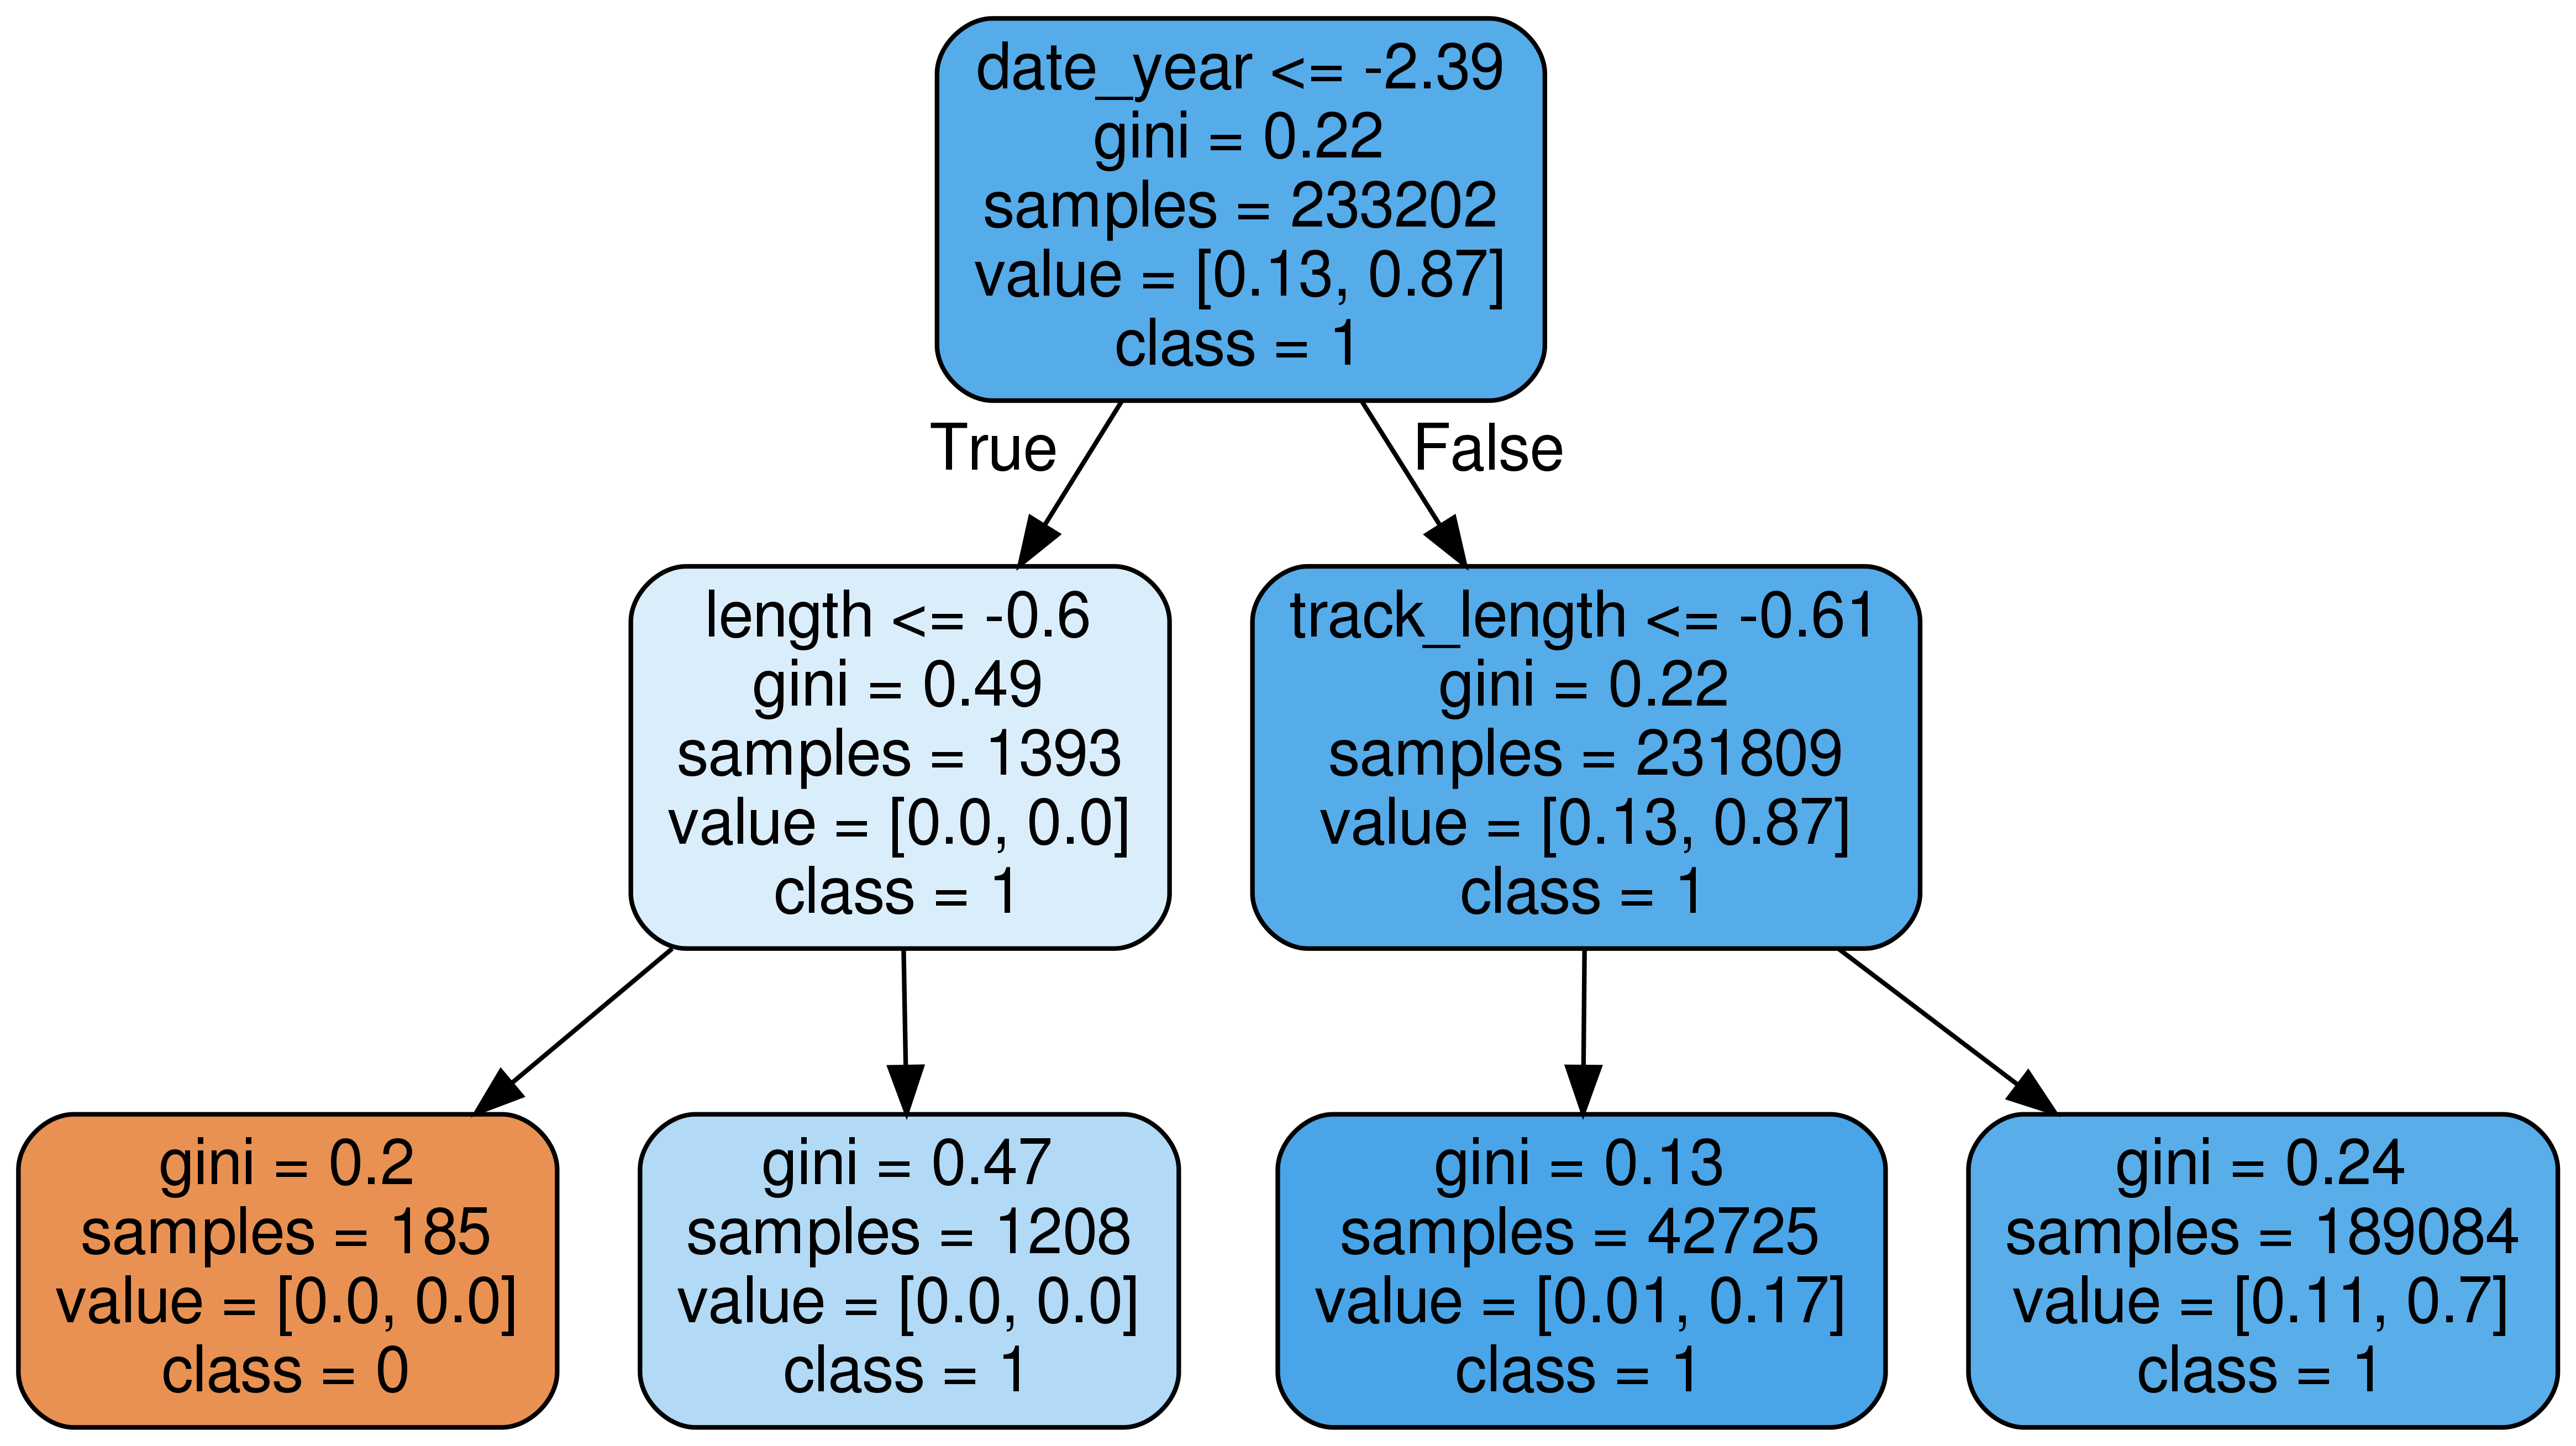

In [22]:
estimator = adbc.estimators_[1]
export_graphviz(estimator, out_file='../figures/tree_adaboost2.dot', 
                feature_names = X_other.columns,
                class_names = ['0','1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

call(['dot', '-Tpng', '../figures/tree_adaboost2.dot', '-o', '../figures/tree_adaboost2.png', '-Gdpi=600'])

# Display in jupyter notebook

Image(filename = '../figures/tree_adaboost2.png')

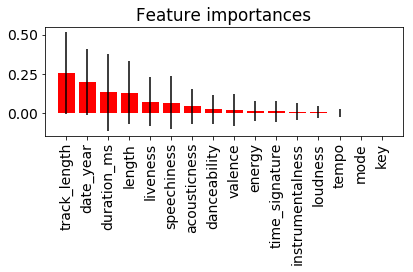

In [25]:
importances = adbc.feature_importances_
std = np.std([tree.feature_importances_ for tree in adbc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_other.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_other.shape[1]), X_other.columns[indices],rotation=90)
plt.xlim([-1, X_other.shape[1]])
plt.tight_layout()
plt.savefig('../figures/feature_imp_adaboost.png')
plt.show()

In [27]:
nr_runs = 10
scores = np.zeros([len(X_test.columns),nr_runs])

test_score = grid_adaboost.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = ',np.sum(y_test == 1)/len(y_test))
# loop through the features
for i in range(len(X_test.columns)):
    print('shuffling '+str(X_test.columns[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[X_test.columns[i]] = np.random.permutation(X_test[X_test.columns[i]].values)
        acc_scores.append(grid_randomforest.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.8825653296283908
test baseline =  0.8806957058687318
shuffling length
   shuffled test score: 0.879 +/- 0.0
shuffling key
   shuffled test score: 0.883 +/- 0.0
shuffling duration_ms
   shuffled test score: 0.883 +/- 0.0
shuffling tempo
   shuffled test score: 0.883 +/- 0.0
shuffling time_signature
   shuffled test score: 0.883 +/- 0.0
shuffling loudness
   shuffled test score: 0.883 +/- 0.0
shuffling date_year
   shuffled test score: 0.883 +/- 0.0
shuffling acousticness
   shuffled test score: 0.883 +/- 0.0
shuffling speechiness
   shuffled test score: 0.883 +/- 0.0
shuffling instrumentalness
   shuffled test score: 0.883 +/- 0.0
shuffling danceability
   shuffled test score: 0.883 +/- 0.0
shuffling valence
   shuffled test score: 0.883 +/- 0.0
shuffling liveness
   shuffled test score: 0.883 +/- 0.0
shuffling mode
   shuffled test score: 0.883 +/- 0.0
shuffling energy
   shuffled test score: 0.883 +/- 0.0
shuffling track_length
   shuffled test score: 0.883 +/- 0.0


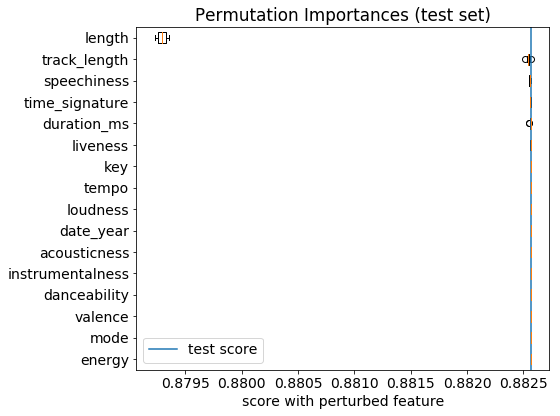

In [28]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=(X_test.columns)[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig(plt.savefig('../figures/feature_perm_imp_adaboost.png'))
plt.show()

---

In [123]:
ls ../results/logistic/

grid0.logistic  grid1.logistic  grid2.logistic  grid3.logistic


In [124]:
for i in ['grid0.logistic','grid1.logistic','grid2.logistic','grid3.logistic']:
    file = open('../results/logistic/'+i, 'rb')
    grid = pickle.load(file)
    file.close()
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:',grid.score(X_test,y_test))

{'logisticregression__C': 0.0001, 'logisticregression__penalty': 'l1'}
best CV score: 0.8925995490044493
test score: 0.8806957058687318
{'logisticregression__C': 0.0001, 'logisticregression__penalty': 'l1'}
best CV score: 0.8925995490044493
test score: 0.8806957058687318
{'logisticregression__C': 0.0001, 'logisticregression__penalty': 'l1'}
best CV score: 0.8925995490044493
test score: 0.8806957058687318
{'logisticregression__C': 0.0001, 'logisticregression__penalty': 'l1'}
best CV score: 0.8925995490044493
test score: 0.8806957058687318


In [128]:
file = open('../results/logistic/grid1.logistic', 'rb')
grid_logistic = pickle.load(file)
file.close()
logistic = grid_logistic.best_estimator_['logisticregression']
logistic.decision_function

<bound method LinearClassifierMixin.decision_function of LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)>

test score: 0.8806957058687318


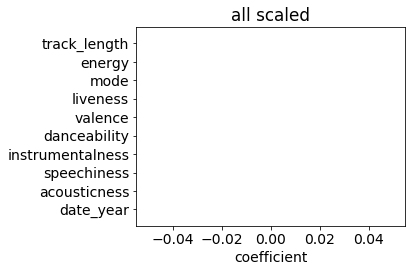

In [132]:

print('test score:',grid_logistic.score(X_test,y_test))
coefs = grid_logistic.best_estimator_[-1].coef_[0]
sorted_indcs = np.argsort(np.abs(coefs))

plt.rcParams.update({'font.size': 14})
plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
plt.yticks(np.arange(10),X_other.columns[sorted_indcs[-10:]])
plt.xlabel('coefficient')
plt.title('all scaled')
plt.tight_layout()
#plt.savefig('../figures/LR_coefs_scaled.png',dpi=300)
plt.show()

In [29]:
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = grid_adaboost.predict(X_test)
print(confusion_matrix(y_true,y_pred))

[[   218  13693]
 [     0 102690]]


In [30]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.array(classes)
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

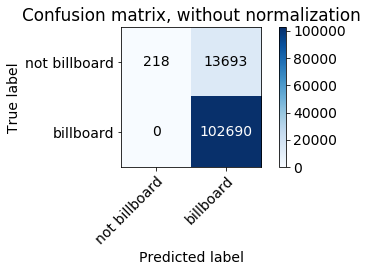

In [31]:
plot_confusion_matrix(y_true,y_pred,classes=['not billboard','billboard'])
plt.tight_layout()
plt.savefig('../figures/adaboost_cm.png')
plt.show()